In [1]:
!pip install stellargraph

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install auto-sklearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# Importing Libraries
# please do go through this python notebook: 
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd # Pandas to create small dataframes 
import numpy as np
import datetime # Convert to unix time
import time # Convert to unix time
# If numpy is not installed already : pip3 install numpy
import numpy as np # Do aritmetic operations on arrays
# Matplotlib: used to plot graphs
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns # Plots
from matplotlib import rcParams # Size of plots  
import math
import pickle
import os
# To install xgboost: pip3 install xgboost
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

import warnings
import networkx as nx
import pdb
import pickle
from tqdm.notebook import tqdm
import os
import random
from sklearn.model_selection import train_test_split

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
data_path = "gdrive/My Drive/Twitch Link Prediction/FR/"

In [6]:
df_train = pd.read_csv(data_path+"fr_pos_train_91.csv").drop(columns = ['Unnamed: 0'])

In [7]:
df_train.head()

,src,dest,link
0,2584,3165,1
1,4150,5718,1
2,1506,6499,1
3,1910,2987,1
4,90,6420,1


In [8]:
import tensorflow

In [9]:
from tensorflow import keras

In [10]:
from stellargraph.core import StellarGraph
from stellargraph.core import StellarDiGraph
from stellargraph.mapper import AdjacencyPowerGenerator
from stellargraph.layer import WatchYourStep
from stellargraph.losses import graph_log_likelihood
from stellargraph.utils import plot_history

from tensorflow.keras import optimizers, Model, layers, regularizers
import tensorflow as tf

In [11]:
from stellargraph.data import EdgeSplitter, UniformRandomWalk, UnsupervisedSampler
from stellargraph.mapper import GraphSAGELinkGenerator
from stellargraph.layer import GraphSAGE, link_classification

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

In [12]:
train_graph = nx.from_pandas_edgelist(df_train, source='src', target='dest', create_using=nx.DiGraph())

In [13]:
degrees = nx.degree(train_graph)

In [14]:
degrees = dict(degrees)

In [15]:
import collections
features = {}
for key, val in degrees.items():
  features[key] = [val]

In [16]:
pr = nx.pagerank(train_graph, alpha=0.85)
pr = dict(pr)
for key, val in pr.items():
  features[key].append(val)

In [17]:
katz = nx.katz_centrality(train_graph,alpha=0.005,beta=1)
katz = dict(katz)
for key, val in katz.items():
  features[key].append(val)

In [18]:
features[0]

[9, 4.753925156945405e-05, 0.010938130450162694]

In [19]:
nx.set_node_attributes(train_graph, features, "features")

In [20]:
G = StellarGraph.from_networkx(train_graph, node_features="features")

In [21]:
print(G.info())

StellarDiGraph: Directed multigraph
 Nodes: 6549, Edges: 101398

 Node types:
  default: [6549]
    Features: float32 vector, length 3
    Edge types: default-default->default

 Edge types:
    default-default->default: [101398]
        Weights: all 1 (default)
        Features: none


In [22]:
nodes = list(G.nodes())
num_walks = 1
len = 5

In [23]:
unsupervised_samples = UnsupervisedSampler(
    G, nodes=nodes, length= len, number_of_walks = num_walks
)

In [24]:
batch_size=128
epochs=20
num_samples= [10,5]

In [25]:
generator = GraphSAGELinkGenerator(G, batch_size, num_samples)
train_gen = generator.flow(unsupervised_samples)

In [26]:
layer_sizes = [64,64]
graphsage = GraphSAGE(
    layer_sizes = layer_sizes, generator = generator, bias = True, normalize='l2'
)

In [27]:
x_inp, x_out = graphsage.in_out_tensors()

In [28]:
prediction = link_classification(
    output_dim = 1, output_act = "sigmoid", edge_embedding_method = "ip"
)(x_out)

link_classification: using 'ip' method to combine node embeddings into edge embeddings


In [29]:
model = keras.Model(inputs = x_inp, outputs = prediction)
model.compile(
    optimizer = keras.optimizers.Adam(1e-2),
    loss = keras.losses.binary_crossentropy,
    metrics = [keras.metrics.binary_accuracy]
)

In [30]:
history = model.fit(
    train_gen,
    epochs=epochs,
    verbose=1,
    use_multiprocessing=True,
    shuffle=True,
)
filep = open(data_path+"graphsage_model.h5", "wb")
pickle.dump(model, filep)
filep.close()

Epoch 1/20
410/410 [==============================] - 48s 106ms/step - loss: 0.7366 - binary_accuracy: 0.5069
Epoch 2/20
410/410 [==============================] - 41s 99ms/step - loss: 0.7294 - binary_accuracy: 0.5148
Epoch 3/20
410/410 [==============================] - 50s 121ms/step - loss: 0.7270 - binary_accuracy: 0.5211
Epoch 4/20
410/410 [==============================] - 42s 103ms/step - loss: 0.7268 - binary_accuracy: 0.5162
Epoch 5/20
410/410 [==============================] - 41s 100ms/step - loss: 0.7252 - binary_accuracy: 0.5209
Epoch 6/20
410/410 [==============================] - 42s 101ms/step - loss: 0.7244 - binary_accuracy: 0.5233
Epoch 7/20
410/410 [==============================] - 41s 99ms/step - loss: 0.7225 - binary_accuracy: 0.5259
Epoch 8/20
410/410 [==============================] - 41s 101ms/step - loss: 0.7188 - binary_accuracy: 0.5279
Epoch 9/20
410/410 [==============================] - 43s 105ms/step - loss: 0.7120 - binary_accuracy: 0.5336
Epoch 10/20


In [31]:
x_inp_src = x_inp[0::2]
x_out_src = x_out[0]
embedding_model = keras.Model(inputs=x_inp_src, outputs=x_out_src)

In [32]:
from stellargraph.mapper.sampled_node_generators import GraphSAGENodeGenerator
node_ids = list(sorted(G.nodes()))
node_gen = GraphSAGENodeGenerator(G, batch_size, num_samples).flow(node_ids)

In [33]:
node_emb = embedding_model.predict(node_gen, verbose=1)

52/52 [==============================] - 3s 57ms/step


In [34]:
type(node_emb)

numpy.ndarray

In [35]:
node_emb.shape

(6549, 64)

In [37]:
node_emb[0].reshape(1,64).shape

(1, 64)

In [39]:
emb_dict = {}
for i, node in enumerate(node_ids):
  emb_dict[node] = np.array(node_emb[i].reshape(1,64))

In [40]:
combined = pd.read_csv(data_path+"/fr_train_91.csv", index_col = 0)
combined.head()

,src,dest,link
91969,3701,4740,1
10839,4621,311,0
50478,3629,1296,0
28091,2207,6183,0
60716,2157,4195,1


In [41]:
# get training embeddings
train_emb = []
for i, row in tqdm(combined.iterrows()):
  comb_emb = (emb_dict[row['src']]) * (emb_dict[row['dest']])
  train_emb.append(comb_emb[0])
train_emb = np.array(train_emb)

0it [00:00, ?it/s]

In [42]:
train_y = combined['link']
train_y.shape

(202198,)

In [43]:
combined_test = pd.read_csv(data_path+"/fr_test_91.csv", index_col = 0)
combined_test.head()

,src,dest,link
90380,3217,1963,0
20879,708,2898,1
32817,197,3988,0
35326,5295,3757,0
1761,58,1025,1


In [44]:
# get test embeddings
test_emb = []
for i, row in tqdm(combined_test.iterrows()):
  comb_emb = (emb_dict[row['src']]) * (emb_dict[row['dest']])
  test_emb.append(comb_emb[0])

print(type(test_emb))
test_emb = np.array(test_emb)
print(test_emb.shape)
test_y = combined_test['link'] 

0it [00:00, ?it/s]

<class 'list'>
(22468, 64)


In [45]:
train_emb_sample, _, train_y_sample, _ = train_test_split(train_emb, train_y, stratify = train_y, test_size = 0.5, random_state = 42)

In [46]:
train_emb_sample.shape

(101099, 64)

In [48]:
from lightgbm import LGBMClassifier
clf = LGBMClassifier(boosting_type='gbdt', num_leaves=31, max_depth=-1, learning_rate=0.1, n_estimators=100, subsample_for_bin=200000, 
                     objective=None, class_weight=None, min_split_gain=0.0, min_child_weight=0.001, min_child_samples=20, subsample=1.0, 
                     subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0, random_state=None, n_jobs=- 1, importance_type='split')
clf.fit(train_emb, train_y)
train_sc = f1_score(train_y,clf.predict(train_emb))
test_sc = f1_score(test_y,clf.predict(test_emb))
print('Train Score',train_sc,'test Score',test_sc)

Train Score 0.8450086067182734 test Score 0.8349993153498562


In [47]:
#reading
from pandas import read_hdf
df_final_train = read_hdf(data_path + 'fr_fea_sample/fr_storage_sample_stage4.h5', 'train_df',mode='r')
df_final_test = read_hdf(data_path + 'fr_fea_sample/fr_storage_sample_stage4.h5', 'test_df',mode='r')

In [49]:
df_final_train.columns

Index(['src', 'dest', 'link', 'jaccard_followers', 'jaccard_followees',
       'cosine_followers', 'cosine_followees', 'num_followers_s',
       'num_followers_d', 'num_followees_s', 'num_followees_d',
       'inter_followers', 'inter_followees', 'adar_index', 'follows_back',
       'same_comp', 'shortest_path', 'weight_in', 'weight_out', 'weight_f1',
       'weight_f2', 'weight_f3', 'weight_f4', 'page_rank_s', 'page_rank_d',
       'katz_s', 'katz_d', 'hubs_s', 'hubs_d', 'authorities_s',
       'authorities_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4',
       'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
       'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2',
       'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1',
       'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6',
       'svd_dot_u', 'svd_dot_v', 'pref_attach_er', 'pref_attach_ee'],
      dtype='object')

In [50]:
df_final_train.shape

(202198, 59)

In [51]:
y_train = df_final_train.link
y_test = df_final_test.link

In [52]:
df_final_train.drop(['src', 'dest','link'],axis=1,inplace=True)
df_final_test.drop(['src', 'dest','link'],axis=1,inplace=True)

In [53]:
# GraphSAGE only
clf = XGBClassifier(max_depth=7, n_estimators=100, n_jobs=-1,
              random_state=25)
clf.fit(train_emb, train_y)
train_sc = f1_score(train_y,clf.predict(train_emb))
test_sc = f1_score(test_y,clf.predict(test_emb))
print('Train Score',train_sc,'test Score',test_sc)

Train Score 0.8541558865640151 test Score 0.8335383914331282


In [54]:
# GraphSAGE only
clf = RandomForestClassifier(max_depth=12, n_estimators=100, n_jobs=-1,
              random_state=25)
clf.fit(train_emb, train_y)
train_sc = f1_score(train_y,clf.predict(train_emb))
test_sc = f1_score(test_y,clf.predict(test_emb))
print('Train Score',train_sc,'test Score',test_sc)

Train Score 0.8659166088335266 test Score 0.8331344653510785


In [55]:
# GraphSAGE only
from lightgbm import LGBMClassifier
clf = LGBMClassifier(boosting_type='gbdt', num_leaves=31, max_depth=-1, learning_rate=0.1, n_estimators=100, subsample_for_bin=200000, 
                     objective=None, class_weight=None, min_split_gain=0.0, min_child_weight=0.001, min_child_samples=20, subsample=1.0, 
                     subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0, random_state=None, n_jobs=- 1, importance_type='split')
clf.fit(train_emb, train_y)
train_sc = f1_score(train_y,clf.predict(train_emb))
test_sc = f1_score(test_y,clf.predict(test_emb))
print('Train Score',train_sc,'test Score',test_sc)

Train Score 0.8450086067182734 test Score 0.8349993153498562


In [ ]:
# Heuristic only
clf = XGBClassifier(max_depth=7, n_estimators=100, n_jobs=-1,
              random_state=25)
clf.fit(df_final_train,y_train)
train_sc = f1_score(y_train,clf.predict(df_final_train))
test_sc = f1_score(y_test,clf.predict(df_final_test))
print('Train Score',train_sc,'test Score',test_sc)

In [ ]:
# Heuristic only
clf = RandomForestClassifier(max_depth=12, n_estimators=100, n_jobs=-1,
              random_state=25)
clf.fit(df_final_train,y_train)
train_sc = f1_score(y_train,clf.predict(df_final_train))
test_sc = f1_score(y_test,clf.predict(df_final_test))
print('Train Score',train_sc,'test Score',test_sc)

In [ ]:
# Heuristic only
clf = LGBMClassifier(boosting_type='gbdt', num_leaves=31, max_depth=-1, learning_rate=0.1, n_estimators=100, subsample_for_bin=200000, 
                     objective=None, class_weight=None, min_split_gain=0.0, min_child_weight=0.001, min_child_samples=20, subsample=1.0, 
                     subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0, random_state=None, n_jobs=- 1, importance_type='split')
clf.fit(df_final_train,y_train)
train_sc = f1_score(y_train,clf.predict(df_final_train))
test_sc = f1_score(y_test,clf.predict(df_final_test))
print('Train Score',train_sc,'test Score',test_sc)

In [56]:
df_final_train = np.hstack((df_final_train, train_emb))
print(df_final_train.shape)
df_final_test = np.hstack((df_final_test, test_emb))
print(df_final_test.shape)

(202198, 120)
(22468, 120)


In [57]:
# Heuristic + GraphSAGE
clf = XGBClassifier(max_depth=7, n_estimators=100, n_jobs=-1,
              random_state=25)
clf.fit(df_final_train,y_train)
train_sc = f1_score(y_train,clf.predict(df_final_train))
test_sc = f1_score(y_test,clf.predict(df_final_test))
print('Train Score',train_sc,'test Score',test_sc)

Train Score 0.9579921502998425 test Score 0.8888888888888888


In [58]:
# Heuristic + GraphSAGE
clf = RandomForestClassifier(max_depth=12, n_estimators=100, n_jobs=-1,
              random_state=25)
clf.fit(df_final_train,y_train)
train_sc = f1_score(y_train,clf.predict(df_final_train))
test_sc = f1_score(y_test,clf.predict(df_final_test))
print('Train Score',train_sc,'test Score',test_sc)

Train Score 0.9532344986872495 test Score 0.8916528468767275


In [59]:
# Heuristic + GraphSAGE
clf = LGBMClassifier(boosting_type='gbdt', num_leaves=31, max_depth=-1, learning_rate=0.1, n_estimators=100, subsample_for_bin=200000, 
                     objective=None, class_weight=None, min_split_gain=0.0, min_child_weight=0.001, min_child_samples=20, subsample=1.0, 
                     subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0, random_state=None, n_jobs=- 1, importance_type='split')
clf.fit(df_final_train,y_train)
train_sc = f1_score(y_train,clf.predict(df_final_train))
test_sc = f1_score(y_test,clf.predict(df_final_test))
print('Train Score',train_sc,'test Score',test_sc)

Train Score 0.9554861925684407 test Score 0.8909125224120034


In [60]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

In [61]:
clf.fit(df_final_train,y_train)
y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)

Train confusion_matrix


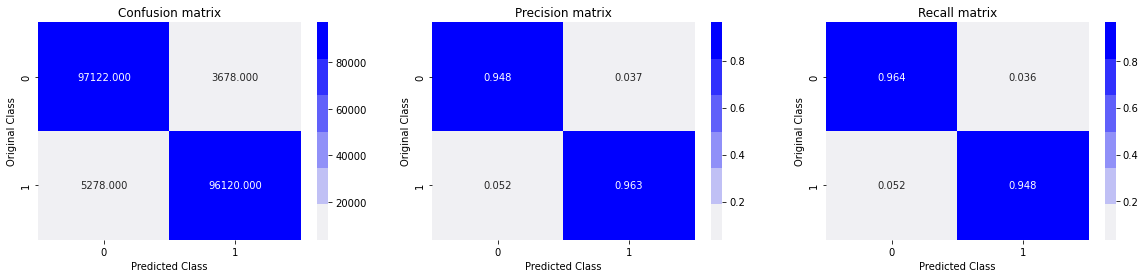

Test confusion_matrix


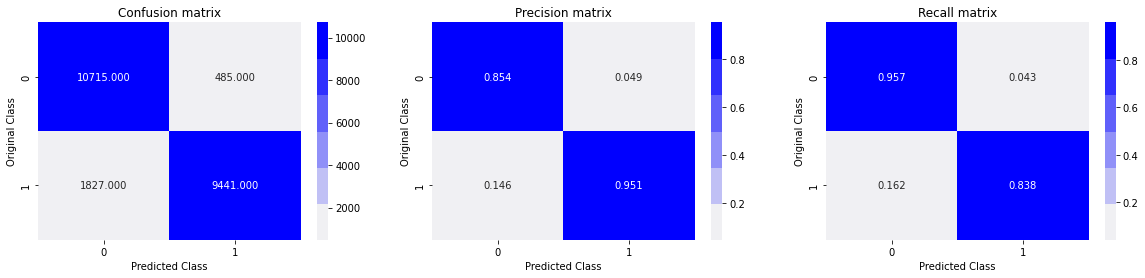

In [62]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

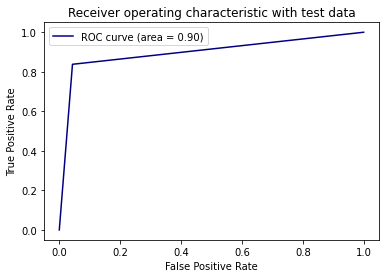

In [63]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

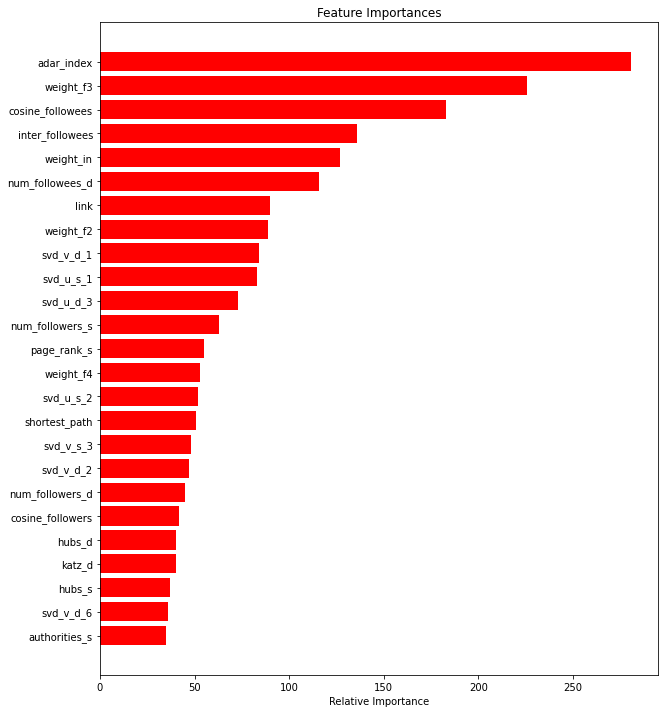

In [64]:
features = ['src', 'dest', 'link', 'jaccard_followers', 'jaccard_followees',
       'cosine_followers', 'cosine_followees', 'num_followers_s',
       'num_followers_d', 'num_followees_s', 'num_followees_d',
       'inter_followers', 'inter_followees', 'adar_index', 'follows_back',
       'same_comp', 'shortest_path', 'weight_in', 'weight_out', 'weight_f1',
       'weight_f2', 'weight_f3', 'weight_f4', 'page_rank_s', 'page_rank_d',
       'katz_s', 'katz_d', 'hubs_s', 'hubs_d', 'authorities_s',
       'authorities_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4',
       'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
       'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2',
       'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1',
       'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6',
       'svd_dot_u', 'svd_dot_v', 'pref_attach_er', 'pref_attach_ee'] + ['w' + str(i) for i in range(1, 65)]

importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(25), importances[indices], color='r', align='center')
plt.yticks(range(25), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()